In [71]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')   

In [72]:
#Reading and cleaning input for master file
TC = pd.read_excel("Test_results_for_POC_21092018.xlsx")
Defects = pd.read_excel("Defect_results_for_POC_21092018.xlsx")
df1 = pd.read_excel("Testcases_CTC_MS_for_POC_27092018.xlsx")
print("Reading Past Test & Defect Data ......")
TC.columns = TC.columns.str.replace(' ', '_')
Defects.columns = Defects.columns.str.replace(' ', '_')
df1.columns = df1.columns.str.replace(' ', '_')
Defects = Defects.rename(columns={'Linked_Test_ID': 'Ts_User_08_(Test_ID)','Terminal':'Cy_Terminal_Name', 'Test_Area':'Ts_Test_Area'})
raw_data = pd.merge(TC,df1,how='outer',on=['Ts_Test_Area','Ts_User_08_(Test_ID)','Ts_Name','Ts_Executing_OpCos','Ts_Coverage','Ts_TCD_Releases'])
master = pd.merge(raw_data,Defects,how='outer',on=['Ts_User_08_(Test_ID)','Ts_Test_Area','Cy_Terminal_Name'])
print("Processing the previously read Data .......")
master['Cov_0'],master['Cov_1'],master['Cov_2'],master['Cov_3'],master['Cov_4'],master['Cov_5'],master['Cov_6'],master['Cov_7'] = master['Ts_Coverage'].str.split(';').str
master['Reason to select'] = ''
master = count_pass_fail_ratio(master)
master.to_excel("./output/master.xlsx")
print ("Created Master data after processing for further analysis ")

Reading Past Test & Defect Data ......
Processing the previously read Data .......
Created Master data after processing for further analysis 


## All functions and code

In [73]:
def count_pass_fail_ratio(master) :
    master = master.rename(columns={'Ts_User_08_(Test_ID)': 'test_id'})
    p4 = master.groupby(['test_id','Rn_Status'])
    df = p4.Ts_Name.agg('count').reset_index()
    df = df.rename(columns={'Ts_Name': 'count'})
    df = df[df['count'] > 0]
    pass_df = df[df['Rn_Status'] == 'Passed']
    fail_df = df[df['Rn_Status'] == 'Failed']
    df4 = pd.merge(pass_df,fail_df,how='outer',on=['test_id'])
    df4 = df4.rename(columns={'count_x': 'pass_count','count_y':'fail_count'})
    df4['pass_count'].fillna(0,inplace=True)
    df4['fail_count'].fillna(0,inplace=True)
    df4['pass_ratio'] = df4['pass_count']/(df4['pass_count']+ df4['fail_count'])
    df4.drop(labels=['Rn_Status_x', 'pass_count', 'Rn_Status_y', 'fail_count'], axis=1,inplace=True)
    master = pd.merge(master,df4,how='left',on=['test_id'])
    master = master.rename(columns={'test_id':'Ts_User_08_(Test_ID)'})
    return master

In [74]:
def RN_Diff(diff_df):
    servicenameArray = []
    testname = []
    dict={}
    filter_col = [col for col in diff_df if 'DefectID' in col]
    DefectArray=diff_df[filter_col].iloc[0].dropna().values
    filter_col = [col for col in diff_df if 'Bug Id' in col]
    KnownissueArray=diff_df[filter_col].iloc[0].dropna().values
    release = [diff_df['RH-Latest-RelName'].values[0]]
    if diff_df["GenInfo-IMEI-SV"].values[0] != diff_df["GenInfo-IMEI-SV"].values[1]:
        testname = ['IMEI-SV']
    for i in range(1,11):
        statuslevel='FC-' +str(i)+ '-Status-level'
        servicename='FC-' +str(i)+ '-ServiceName'
        if(diff_df[statuslevel][0]!=diff_df[statuslevel][1]): 
            servicenameArray.append(diff_df[servicename].values[0])
    terminal = diff_df['PD-ProjectName'].values[0]
    dict={'Defect':DefectArray,'known_issue':KnownissueArray,'service_name':servicenameArray,'imei_sv':testname,
     'release_type':release,'terminal':terminal} 
    print("Processing Release difference ....")
    print('dict : ',dict)
    TCFinal= order_filter(dict)
    return (TCFinal)
#RN_Diff(diff_df)

In [75]:
def join_rows(df) :
    new_df = pd.DataFrame(0, index=range(1),columns = ['Cy_Terminal_Name', 'Cy_Terminal_Release', 'Cy_Terminal_SW_Version',
       'Cy_Executing_OpCo', 'Ts_User_08_(Test_ID)', 'Ts_Name', 'Ts_Test_Area',
       'Ts_TCD_Releases', 'Ts_Executing_OpCos', 'Ts_Coverage', 'Rn_Status',
       'Scope_CTC', 'Scope_CZ', 'Scope_DE', 'Scope_HU', 'Scope_IE', 'Scope_NL',
       'Scope_UK', 'Ts_Suggested_Severity', 'Defect_ID', 'Status', 'Severity',
       'Summary', 'Description', 'Also_in_OpCo', 'Reason to select','pass_ratio'])
    for i in range(df.shape[1]) :                       
        temp = set()
        for j in range(df.shape[0]) :
            if j == 0:
                new_df.iloc[j,i] = df.iloc[j,i]
            else :
                if df.iloc[j,i] != new_df.iloc[0,i] :
                    temp.add(str(df.iloc[j,i]))
        if (len(temp) > 0) :
            temp.add(str(new_df.iloc[0,i]))
            new_df.iloc[0,i] = ', '.join(temp)
    return new_df

In [76]:
def format_excel(final,final_nonOptimized) :
    writer = pd.ExcelWriter("./output/FinalTestSuite.xlsx", engine='xlsxwriter')
    final.to_excel(writer, sheet_name='Sheet1', startrow=1, header=False,index=False)
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']
    worksheet.set_column('A:AA', 25)
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': True,
        'valign': 'top',
        'fg_color': '#FFCCCC',
        'border': 1})
    for col_num, value in enumerate(final.columns.values):
        worksheet.write(0, col_num, value, header_format)
    writer.save()
    
    writer = pd.ExcelWriter("./output/FinalTestSuite_nonOptimized.xlsx", engine='xlsxwriter')
    final_nonOptimized.to_excel(writer, sheet_name='Sheet1', startrow=1, header=False,index=False)
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']
    worksheet.set_column('A:AN', 25)
    header_format = workbook.add_format({
        'bold': True,
        'text_wrap': True,
        'valign': 'top',
        'fg_color': '#FFCCCC',
        'border': 1})
    for col_num, value in enumerate(final_nonOptimized.columns.values):
        worksheet.write(0, col_num, value, header_format)
    writer.save()

In [77]:
def order_filter(filterparams):
    FinalTC = pd.DataFrame()
    FinalTC_nonOptimized = pd.DataFrame()
    TCexcel1 = pd.DataFrame()
    TCexcel2 = pd.DataFrame()
    TCexcel3 = pd.DataFrame()
    TCexcel4 = pd.DataFrame()
    TCexcel5 = pd.DataFrame()
    areas = set(['Exploratory A','Smart_Customization','VoWiFi','MMS'])
    for key,value in filterparams.items():
        if key == 'Defect':
            if(len(filterparams[key]) != 0) :
                TCexcel1 = Defects_ID (filterparams[key])
        elif key == 'release_type':
            if(len(filterparams[key]) != 0) :
                TCexcel2 = Terminal_Release(filterparams[key])
                TCexcel4 = Terminal_Release_nonOptimized(filterparams[key])
        elif key == 'service_name':
            areas.update(filterparams[key])
        elif key == 'test_area':
            areas.update(filterparams[key])
        elif key == 'terminal':
            Terminal_name = filterparams[key]
    TCexcel3 = Test_area(list(areas))
    TCexcel5 = Test_area_nonOptimized(list(areas))
    FinalTC = FinalTC.append([TCexcel1,TCexcel2,TCexcel3])
    FinalTC_nonOptimized = FinalTC_nonOptimized.append([TCexcel1,TCexcel4,TCexcel5])
    
    FinalTC = FinalTC[(FinalTC['Cy_Terminal_Name'] == Terminal_name) | (FinalTC['Cy_Terminal_Name'] =='Blanc')] 
    FinalTC.dropna(subset=['Ts_Name','Defect_ID'],inplace=True)
    FinalTC.drop(labels=['Cov_0', 'Cov_1', 'Cov_2', 'Cov_3','Cov_4', 'Cov_5', 'Cov_6', 'Cov_7','Rn_Tester_Name','Rn_Execution_Date','Rn_Execution_Time','Ts_Description(draft)'
                        ,'Full_Defect_Comments','Detected_By'],axis=1,inplace=True)
    FinalTC.drop_duplicates(keep='first',inplace=True)
    group = FinalTC.groupby(['Ts_Name'])
    final = pd.DataFrame()
    final = final.append(group.apply(join_rows))
    final = final[['Cy_Terminal_Name', 'Reason to select', 'Ts_Test_Area','Ts_User_08_(Test_ID)','Ts_Name', 'Description', 
                   'Ts_Suggested_Severity', 'Cy_Terminal_Release', 'Cy_Terminal_SW_Version','Cy_Executing_OpCo', 
       'Ts_TCD_Releases', 'Ts_Executing_OpCos', 'Ts_Coverage', 'Rn_Status', 'Scope_CTC', 'Scope_CZ', 'Scope_DE', 'Scope_HU', 
                   'Scope_IE', 'Scope_NL', 'Scope_UK',  'Defect_ID', 'Summary','Status', 'Severity', 'Also_in_OpCo']]
    final = final.rename(columns={'Description': 'Test Description','Summary':'Defect Summary'})
    
    # final tc non optimized
    FinalTC_nonOptimized = FinalTC_nonOptimized[(FinalTC_nonOptimized['Cy_Terminal_Name'] == Terminal_name) | (FinalTC_nonOptimized['Cy_Terminal_Name'] =='Blanc')] 
    FinalTC_nonOptimized.dropna(subset=['Ts_Name','Defect_ID'],inplace=True)
    FinalTC_nonOptimized.drop(labels=['Cov_0', 'Cov_1', 'Cov_2', 'Cov_3','Cov_4', 'Cov_5', 'Cov_6', 'Cov_7','Rn_Tester_Name','Rn_Execution_Date','Rn_Execution_Time','Ts_Description(draft)'
                        ,'Full_Defect_Comments','Detected_By'],axis=1,inplace=True)
    FinalTC_nonOptimized.drop_duplicates(keep='first',inplace=True)
    group = FinalTC_nonOptimized.groupby(['Ts_Name'])
    final_nonOptimized = pd.DataFrame()
    final_nonOptimized = final_nonOptimized.append(group.apply(join_rows))
    final_nonOptimized = final_nonOptimized[['Cy_Terminal_Name', 'Reason to select', 'Ts_Test_Area','Ts_User_08_(Test_ID)','Ts_Name', 'Description', 
                   'Ts_Suggested_Severity', 'Cy_Terminal_Release', 'Cy_Terminal_SW_Version','Cy_Executing_OpCo', 
       'Ts_TCD_Releases', 'Ts_Executing_OpCos', 'Ts_Coverage', 'Rn_Status', 'Scope_CTC', 'Scope_CZ', 'Scope_DE', 'Scope_HU', 
                   'Scope_IE', 'Scope_NL', 'Scope_UK',  'Defect_ID', 'Summary','Status', 'Severity', 'Also_in_OpCo']]
    final_nonOptimized = final_nonOptimized.rename(columns={'Description': 'Test Description','Summary':'Defect Summary'})
    
    format_excel(final,final_nonOptimized)
    
    print('Processed Successfully -Final Test case sheet is available at: {0}'.format(os.getcwd()))
    return final 
#tc = order_filter(dict)

In [78]:
def Terminal_Release(release_name):
    TCexcel = pd.DataFrame()
    cycle_type = 'SH'
    for rel in release_name:
        TCexcel = TCexcel.append(master.loc[master['Cy_Terminal_Release'].str.slice(0,3) == rel ]) 
        TCexcel= TCexcel[(TCexcel['Cov_1']==cycle_type) | (TCexcel['Cov_2']==cycle_type) | 
                                           (TCexcel['Cov_3']==cycle_type) |(TCexcel['Cov_4']==cycle_type) |
                                           (TCexcel['Cov_5']==cycle_type)|(TCexcel['Cov_6']==cycle_type)|
                         (TCexcel['Cov_7']==cycle_type)|(TCexcel['Cov_0']==cycle_type)]
    TCexcel = TCexcel[(TCexcel['Ts_Suggested_Severity']== '2 - Serious') | (TCexcel['Ts_Suggested_Severity']== '1a - Fatal') | 
                                           (TCexcel['Ts_Suggested_Severity']== '3 - Major') |(TCexcel['Rn_Status']== 'Failed')|
                      (TCexcel['Status'] == 'Closed' )]
    TCexcel = TCexcel[(TCexcel['Rn_Status']== 'Failed') | ((TCexcel['Rn_Status']== 'Passed') & (TCexcel['pass_ratio'] < 0.8 ))]
    TCexcel['Reason to select'] = np.where(TCexcel['Cy_Terminal_Release'].str.slice(0,3)== rel, 'Terminal release is :{0} hence cycle type  {1}'.format(rel, cycle_type),'none')
    excel = TCexcel.to_excel('./output/TC_for_execution_Release_based.xlsx')
    return (TCexcel)
#t = Terminal_Release(['MR0'])

In [79]:
def Terminal_Release_nonOptimized(release_name):
    TCexcel = pd.DataFrame()
    cycle_type = 'SH'
    for rel in release_name:
        TCexcel = TCexcel.append(master.loc[master['Cy_Terminal_Release'].str.slice(0,3) == rel ]) 
        TCexcel= TCexcel[(TCexcel['Cov_1']==cycle_type) | (TCexcel['Cov_2']==cycle_type) | 
                                           (TCexcel['Cov_3']==cycle_type) |(TCexcel['Cov_4']==cycle_type) |
                                           (TCexcel['Cov_5']==cycle_type)|(TCexcel['Cov_6']==cycle_type)|
                         (TCexcel['Cov_7']==cycle_type)|(TCexcel['Cov_0']==cycle_type)]
    TCexcel = TCexcel[(TCexcel['Ts_Suggested_Severity']== '2 - Serious') | (TCexcel['Ts_Suggested_Severity']== '1a - Fatal') | 
                                           (TCexcel['Ts_Suggested_Severity']== '3 - Major') |(TCexcel['Rn_Status']== 'Failed')|
                      (TCexcel['Status'] == 'Closed' )]
    TCexcel['Reason to select'] = np.where(TCexcel['Cy_Terminal_Release'].str.slice(0,3)== rel, 'Terminal release is :{0} hence cycle type  {1}'.format(rel, cycle_type),'none')
    excel = TCexcel.to_excel('./output/TC_for_execution_Release_based_nonOptimized.xlsx')
    return (TCexcel)

In [80]:
def Test_area(testarea):
    TCexcel = pd.DataFrame()
    cycle_type = 'OE'
    for area in testarea:
        if (area =='Exploratory A'):
            cycle_type = 'SH'
        df = master.loc[master['Ts_Test_Area'] == area]
        df['Reason to select'] = 'Change in version/status of test area :{0} hence cycle type  {1}'.format(area, cycle_type) 
        TCexcel = TCexcel.append(df)
        TCexcel= TCexcel[(TCexcel['Cov_1']==cycle_type) | (TCexcel['Cov_2']==cycle_type) | 
                                           (TCexcel['Cov_3']==cycle_type) |(TCexcel['Cov_4']==cycle_type) |
                                           (TCexcel['Cov_5']==cycle_type)|(TCexcel['Cov_6']==cycle_type)|
                                           (TCexcel['Cov_7']==cycle_type)|(TCexcel['Cov_0']==cycle_type)]
        if cycle_type == 'SH':
            TCexcel= TCexcel[(TCexcel['Ts_Suggested_Severity']== '2 - Serious') | (TCexcel['Ts_Suggested_Severity']== '1a - Fatal') | 
                                           (TCexcel['Ts_Suggested_Severity']== '3 - Major') |(TCexcel['Rn_Status']== 'Failed')]
    TCexcel = TCexcel[(TCexcel['Rn_Status']== 'Failed') | ((TCexcel['Rn_Status']== 'Passed') & (TCexcel['pass_ratio'] < 0.8 ))]
    #TCexcel.to_excel('area.xlsx',index=False)
    return (TCexcel)
#t = Test_area(['Exploratory A','IMEI-SV'])

In [81]:
def Test_area_nonOptimized(testarea):
    TCexcel = pd.DataFrame()
    cycle_type = 'OE'
    for area in testarea:
        if (area =='Exploratory A'):
            cycle_type = 'SH'
        df = master.loc[master['Ts_Test_Area'] == area]
        df['Reason to select'] = 'Change in version/status of test area :{0} hence cycle type  {1}'.format(area, cycle_type) 
        TCexcel = TCexcel.append(df)
        TCexcel= TCexcel[(TCexcel['Cov_1']==cycle_type) | (TCexcel['Cov_2']==cycle_type) | 
                                           (TCexcel['Cov_3']==cycle_type) |(TCexcel['Cov_4']==cycle_type) |
                                           (TCexcel['Cov_5']==cycle_type)|(TCexcel['Cov_6']==cycle_type)|
                                           (TCexcel['Cov_7']==cycle_type)|(TCexcel['Cov_0']==cycle_type)]
        if cycle_type == 'SH':
            TCexcel= TCexcel[(TCexcel['Ts_Suggested_Severity']== '2 - Serious') | (TCexcel['Ts_Suggested_Severity']== '1a - Fatal') | 
                                           (TCexcel['Ts_Suggested_Severity']== '3 - Major') |(TCexcel['Rn_Status']== 'Failed')]
    return (TCexcel)

In [82]:
def Defects_ID (defectid):
    TCexcel = pd.DataFrame()
    TCexcel1 = pd.DataFrame()
    for ids in defectid:
        cycle_type = 'SH'
        sev_check =  set(master.loc[master['Defect_ID'] == ids]['Severity'])
        for sev in sev_check :
            if(sev in ['4 - Minor' , '3 - Major'] ):
                cycle_type = 'BF'
        TCarea = set(master.loc[master['Defect_ID'] == ids]['Ts_Test_Area'])
        TCname = set(master.loc[master['Defect_ID'] == ids]['Ts_Name'])
        TCopco = set(master.loc[master['Defect_ID'] == ids]['Ts_Executing_OpCos'])
        for area in TCarea :
            df = master.loc[master['Ts_Test_Area'] == area]
            df['Reason to select'] = 'TC belongs to area:{0} for defect id:{1}'.format(area, ids)
            TCexcel = TCexcel.append(df)
            TCexcel= TCexcel[(TCexcel['Cov_1']==cycle_type) | (TCexcel['Cov_2']==cycle_type) | 
                                           (TCexcel['Cov_3']==cycle_type) |(TCexcel['Cov_4']==cycle_type) |
                                           (TCexcel['Cov_5']==cycle_type)|(TCexcel['Cov_6']==cycle_type)|
                                           (TCexcel['Cov_7']==cycle_type)|(TCexcel['Cov_0']==cycle_type)]
            TCexcel = TCexcel.append(master.loc[master['Ts_Executing_OpCos'] == TCopco])
        if cycle_type == 'SH':
            TCexcel= TCexcel[(TCexcel['Ts_Suggested_Severity']== '2 - Serious') | (TCexcel['Ts_Suggested_Severity']== '1a - Fatal') | 
                                           (TCexcel['Ts_Suggested_Severity']== '3 - Major') |(TCexcel['Rn_Status']== 'Failed')]
        elif cycle_type == 'BF':
            TCexcel= TCexcel[TCexcel['Rn_Status']== 'Failed']
    
        for name in TCname:
            if name :
                if (TCexcel['Ts_Name'].any() == name ) :
                    TCexcel['Reason to select'] = np.where(TCexcel['Ts_Name'] == name, 'linked TC for defect id:{0}'.format(ids),'none')
                else : 
                    TCexcel = TCexcel.append( master[ (master['Ts_Name'] == name) & (master['Defect_ID'] == ids)])
                    #TCexcel['Reason to select'] = (TCexcel['Ts_Name'] == name, 'linked TC for defect id:{0}'.format(ids),'none')
                    TCexcel.loc[TCexcel['Ts_Name'] == name, 'Reason to select'] = 'linked TC for defect id:{0}'.format(ids)    
        TCexcel1 = TCexcel1.append(TCexcel)
    excel = TCexcel1.to_excel('./output/TC_for_execution_defect_based.xlsx')
    return (TCexcel1)
#t = TCexcel = Defects_ID ([24093, 23993, 25649])
#t.to_excel('defect_id.xlsx')

In [83]:
def take_second_release_notes(diff_df) :
    file2 = input('Please enter excel file names of previous release : ' )
    if(not (file2.endswith('.xls') or file2.endswith('.xlsx'))) :
        file2 = file2+'.xlsx'
    if(not(os.path.isfile(file2))) :
        print('no file found for given name : '+file2)
        take_second_release_notes(diff_df)
    row2 = pd.read_excel(file2)
    print(diff_df['RH-Latest-RelName'])
    if(row2.empty) :
        print('Given excel file is empty')
        take_second_release_notes(diff_df)
    if(row2.duplicated(subset=' Release Notes Name').any() == True) :
        print('Given file contains duplicate column names.Please update it.')
        take_second_release_notes(diff_df)
    diff_df = diff_df.append(row2.set_index(' Release Notes Name').T)
    RN_Diff(diff_df)

In [84]:
def take_latest_release_notes() :
    file1 = input('Please enter excel file names of latest release : ' )       
    if(not (file1.endswith('.xls') or file1.endswith('.xlsx'))) :
        file1 = file1+'.xlsx'
    if(not(os.path.isfile(file1))) :
        print('no file found for given name : '+file1)
        take_latest_release_notes()
    row1 = pd.read_excel(file1)
    if(row1.empty) :
        print('Given excel file is empty')
        take_latest_release_notes()
    if(row1.duplicated(subset=' Release Notes Name').any() == True) :
        print('Given file contains duplicate column names.Please update it.')
        take_latest_release_notes()
    df = row1.set_index(' Release Notes Name').T
    take_second_release_notes(df)        


# Data Analysis and plots:

<Figure size 864x576 with 0 Axes>

[Text(0,0,'Exploratory A'),
 Text(0,0,'Smart_Customization'),
 Text(0,0,'VoWiFi'),
 Text(0,0,'LTE_Voice_over_LTE'),
 Text(0,0,'Call+_&_Message+_Native'),
 Text(0,0,'Customisation_Settings'),
 Text(0,0,'GSM_and_Basic_Operations'),
 Text(0,0,'Dual_SIM'),
 Text(0,0,'SoR_based_on_SS7'),
 Text(0,0,'NFC-BIP'),
 Text(0,0,'Google_RCS_Sanity_Check')]

Text(0,0.5,'No of Defects')

Text(0.5,0,'Test Area')

Text(0.5,1,'Test Area vs no. Defects(count greater than 20)')

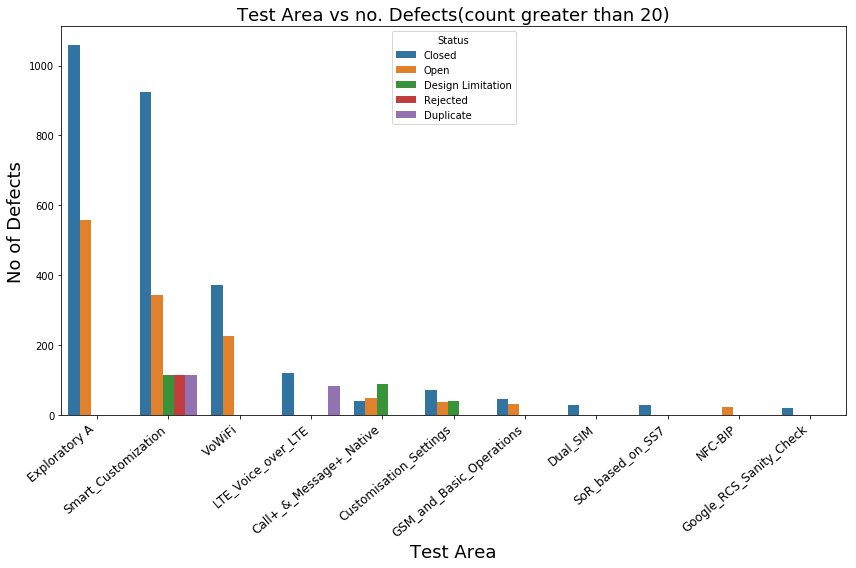

<Figure size 864x576 with 0 Axes>

[Text(0,0,'Exploratory A'),
 Text(0,0,'Smart_Customization'),
 Text(0,0,'VoWiFi'),
 Text(0,0,'Call+_&_Message+_Native'),
 Text(0,0,'Customisation_Settings'),
 Text(0,0,'LTE_Voice_over_LTE')]

Text(0,0.5,'No of testcase')

Text(0.5,0,'Test Area')

Text(0.5,1,'Test Area vs Test case severity distribution')

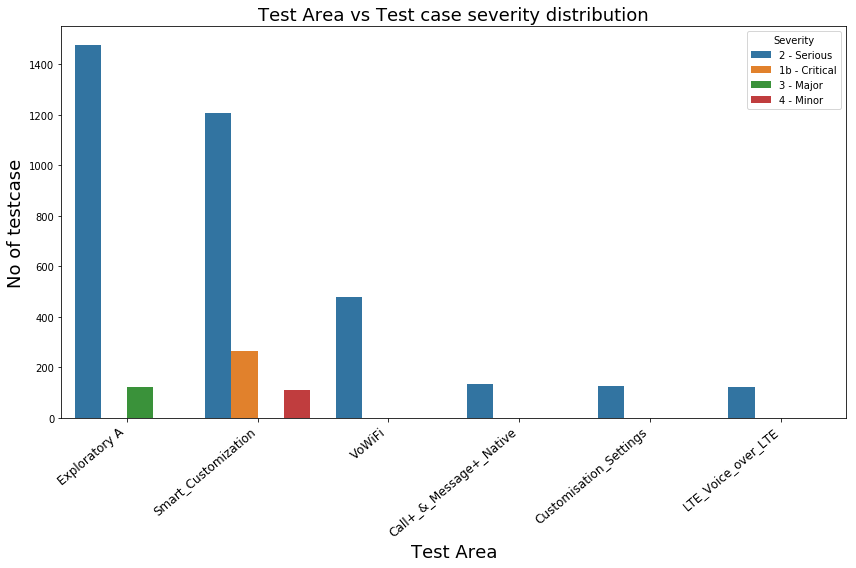

<Figure size 864x576 with 0 Axes>

[Text(0,0,'Exploratory A'),
 Text(0,0,'Smart_Customization'),
 Text(0,0,'LTE_Voice_over_LTE'),
 Text(0,0,'Call+_&_Message+_Native'),
 Text(0,0,'VoWiFi'),
 Text(0,0,'Customisation_Settings'),
 Text(0,0,'LTE_Data'),
 Text(0,0,'Speechcodecs_EVS'),
 Text(0,0,'LTE_Voice_via_CSFB'),
 Text(0,0,'GSM_and_Basic_Operations'),
 Text(0,0,'Call+_&_Message+_Native_IOT'),
 Text(0,0,'Roaming_Data'),
 Text(0,0,'Google_RCS_Sanity_Check'),
 Text(0,0,'APP_BasicTest'),
 Text(0,0,'3G_Handset'),
 Text(0,0,'SoR_based_on_SS7')]

Text(0,0.5,'No of testcase')

Text(0.5,0,'Test Area')

Text(0.5,1,'Test Area vs Test case status distribution')

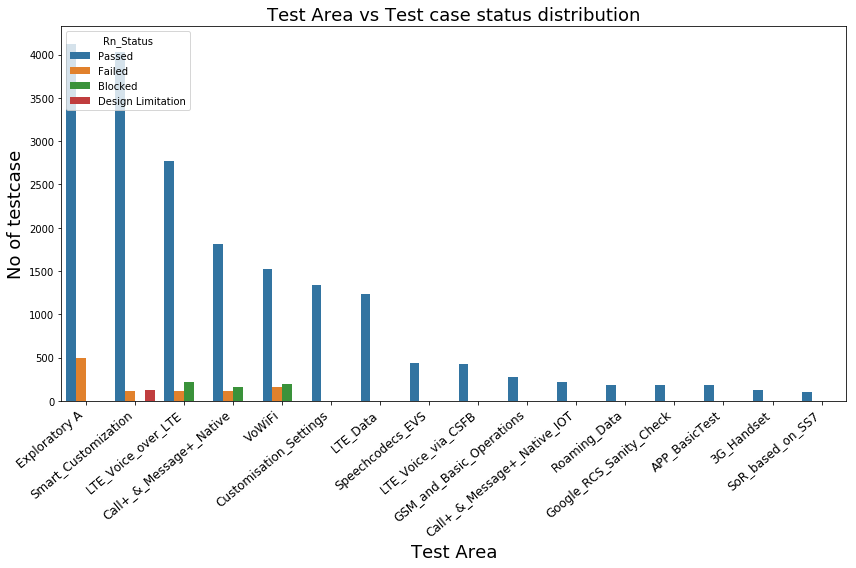

In [85]:

## Test Area vs Test case and defects

### Test area maturity as per defect status

p4 = master.groupby(['Ts_Test_Area', 'Status'])
#round(p4.Defect_ID.count()).sort_values()

df = p4.Defect_ID.agg('count').reset_index()
df = df[df['Defect_ID'] > 20 ]
df = df.sort_values("Defect_ID",ascending=False)
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Defect_ID", x="Ts_Test_Area", data=df,hue='Status')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",fontsize=12)
plt.ylabel('No of Defects',fontsize=18)
plt.xlabel('Test Area',fontsize=18)
plt.title('Test Area vs no. Defects(count greater than 20)',fontsize=18)
plt.tight_layout()
plt.savefig('./output/Test Area vs no. Defects.jpg')
plt.show()




### Testcase Severity for Various Testarea

p6 = master.groupby(['Ts_Test_Area','Severity'])
#round(p6.Ts_Name.count()).sort_values()

df = p6.Ts_Name.agg('count').reset_index()
df = df.sort_values("Ts_Name",ascending=False)
df = df[df['Ts_Name'] > 100 ]
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Ts_Name", x="Ts_Test_Area", data=df,hue='Severity')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",fontsize=12)
plt.ylabel('No of testcase',fontsize=18)
plt.xlabel('Test Area',fontsize=18)
plt.title('Test Area vs Test case severity distribution',fontsize=18)
plt.tight_layout()
plt.savefig('./output/Test Area vs Test case severity distribution1.jpg')
plt.show()



p6 = master.groupby(['Ts_Test_Area','Rn_Status'])
#round(p6.Ts_Name.count()).sort_values()

df = p6.Ts_Name.agg('count').reset_index()
df = df.sort_values("Ts_Name",ascending=False)
df = df[df['Ts_Name'] > 100 ]
plt.figure(figsize=(12,8))
ax = sns.barplot(y="Ts_Name", x="Ts_Test_Area", data=df,hue='Rn_Status')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",fontsize=12)
plt.ylabel('No of testcase',fontsize=18)
plt.xlabel('Test Area',fontsize=18)
plt.title('Test Area vs Test case status distribution',fontsize=18)
plt.tight_layout()
plt.savefig('./output/Test Area vs Test case status distribution1.jpg')
plt.show()



[Text(0,0,'Smart_Customization_Google_PAI'),
 Text(0,0,'NFC-BIP'),
 Text(0,0,'Net-Lock'),
 Text(0,0,'Call+_&_Message+_Native_IOT')]

Text(0,0.5,'fail_ratio')

Text(0.5,0,'Test Area')

Text(0.5,1,'Test Area vs fail_ratio distribution')

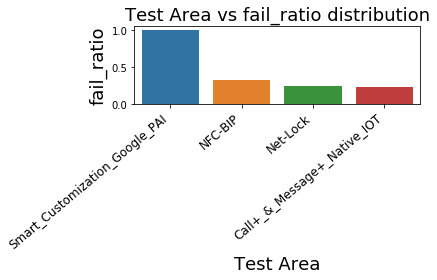

In [86]:
p7 = master.groupby(['Ts_Test_Area'])
df = p7.pass_ratio.mean().reset_index()
df['fail_ratio']= 1-df['pass_ratio']
df = df[df['fail_ratio'] > 0.2 ]
df = df.sort_values("fail_ratio",ascending=False)

#plt.figure(figsize=(20,8))
ax = sns.barplot(y="fail_ratio", x="Ts_Test_Area", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",fontsize=12)
plt.ylabel('fail_ratio',fontsize=18)
plt.xlabel('Test Area',fontsize=18)
plt.title('Test Area vs fail_ratio distribution',fontsize=18)
plt.tight_layout()
plt.savefig('./output/Test Area vs fail_ratio distribution.jpg')
plt.show()

# Provide Release notes:

In [87]:
take_latest_release_notes()

Please enter excel file names of latest release : Release notes_Hima_MR_ L09
Please enter excel file names of previous release : Release notes_Hima_TA_ L09
HUAWEI  HMA-L29 9.0.0.108(C432E10R1P16) for COTA-Normal Release Notes    MR0
Name: RH-Latest-RelName, dtype: object
Processing Release difference ....
dict :  {'Defect': array([24093, 23993, 25649], dtype=object), 'known_issue': array([25718, 25719, 25721, 25722, 25728, 25737], dtype=object), 'service_name': ['VoWiFi', 'Speechcodecs_EVS'], 'imei_sv': [], 'release_type': ['MR0'], 'terminal': 'Hima'}
Processed Successfully -Final Test case sheet is available at: /Users/natashapandya/Desktop/POC/demo/Input
